In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
spark = SparkSession.builder.appName('RTA_Analysis').getOrCreate()

### load dataset to RDD

In [2]:
sc = spark.sparkContext
#CSV_RDD = (sc.textFile("./US_RTA copy.csv",minPartitions = 4).map(lambda element: element.split('\t')))

### load dataset and do some Query (filter the columns that we need)

In [3]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

#df = sqlContext.read.load("./US_Accidents_Dec19.csv",
                             #format='com.databricks.spark.csv',
                             #inferSchema='true',
                             #header='true',
                             #nullValue='NA')
df = spark.read.csv("./US_Accidents_Dec19.csv",header=True,inferSchema=True)

In [4]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (n

### Select the fields that we need

In [5]:
RTA_df = df.select("ID", "Severity", "Start_Time", "End_Time", "Start_Lat",
                   "Start_Lng", "Distance(mi)", "Street", "Side", "City",
                   "Temperature(F)", "Humidity(%)", "Visibility(mi)",
                   "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition",
                   "Bump", "Crossing", "Give_Way", "Junction", "Station",
                   "Stop", "Traffic_Calming", "Traffic_Signal",
                   "Sunrise_Sunset", "Description")

In [6]:
RTA_df.show()

+----+--------+-------------------+-------------------+---------+----------+------------+--------------------+----+------------+--------------+-----------+--------------+---------------+-----------------+-----------------+-----+--------+--------+--------+-------+-----+---------------+--------------+--------------+--------------------+
|  ID|Severity|         Start_Time|           End_Time|Start_Lat| Start_Lng|Distance(mi)|              Street|Side|        City|Temperature(F)|Humidity(%)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weather_Condition| Bump|Crossing|Give_Way|Junction|Station| Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|         Description|
+----+--------+-------------------+-------------------+---------+----------+------------+--------------------+----+------------+--------------+-----------+--------------+---------------+-----------------+-----------------+-----+--------+--------+--------+-------+-----+---------------+--------------+--------------+-----------

In [8]:
RTA_df.count()

2974335

### Test for grouping by day

In [10]:
RTA_df.registerTempTable('RTA_table')

In [58]:
RTA_date = RTA_df.select('ID','Start_Time','`Temperature(F)`','`Humidity(%)`','`Visibility(mi)`','`Wind_Speed(mph)`','Weather_Condition').groupBy(date_format('Start_Time','yyy-MM-dd').alias('Date')).count().show()

+----------+-----+
|      Date|count|
+----------+-----+
|2016-08-17| 2263|
|2017-05-14|  575|
|2019-08-22| 2983|
|2019-08-23| 2826|
|2019-08-08| 2773|
|2017-12-05| 3354|
|2016-09-11|  640|
|2016-08-08| 2309|
|2016-08-20|  676|
|2016-04-22|  927|
|2017-02-24| 2496|
|2017-05-11| 1960|
|2019-09-29| 1331|
|2019-08-31| 1574|
|2019-04-25| 2783|
|2018-12-31| 2501|
|2017-12-22| 3021|
|2017-10-20| 3266|
|2016-07-06| 2148|
|2016-05-21|  367|
+----------+-----+
only showing top 20 rows



### groupbyday and calcualte the average value

In [167]:
RTA_Day = sqlContext.sql(
    'select date(Start_Time) as Day, AVG(`Temperature(F)`) as AverageTemperature, AVG(`Humidity(%)`) as AverageHumidity, AVG(`Visibility(mi)`) as AverageVisibility, AVG(`Wind_Speed(mph)`) as AverageWindSpeed from RTA_table group by date(Start_Time) order by date(Start_Time)'
)

## Data preprocessing

In [246]:
RTA_Day.registerTempTable('RTA_Day')

# Step 1 join replace the nul vlaue with average value of that day
join = 'SELECT * FROM RTA_table FULL OUTER JOIN RTA_Day ON date(Start_Time)=RTA_Day.Day order by Start_Time'
RTA_join = sqlContext.sql(join)
RTA_join = RTA_1.drop('Day')

RTA_join.registerTempTable('RTA_join')

# Step 2 if Precipitation is null, set 0
precipitation = 'SELECT *, ifnull(`Precipitation(in)`, 0) Precipitation FROM RTA_join'
RTA_precipitation = sqlContext.sql(precipitation)
RTA_precipitation = RTA_precipitation.drop('Precipitation(in)')

# Step 3 delete all records who have null value
RTA_final = RTA_precipitation.dropna()
RTA_final.count()



2508771

In [264]:
# Step 4 Severity = 3
RTA_final = RTA_final.filter(RTA_final.Severity == 3)
RTA_final.count()

740230

### Spark RDD

In [265]:
# Dataframe to RDD
RTA_rdd = RTA_final.rdd

In [266]:
# print the first element
RTA_rdd.take(1)

[Row(ID='A-2246288', Severity=3, Start_Time=datetime.datetime(2016, 2, 8, 0, 37, 8), End_Time=datetime.datetime(2016, 2, 8, 6, 37, 8), Start_Lat=40.10891, Start_Lng=-83.09286, Distance(mi)=3.23, Street='Outerbelt E', Side='R', City='Dublin', Temperature(F)=42.1, Humidity(%)=58.0, Visibility(mi)=10.0, Wind_Speed(mph)=10.4, Weather_Condition='Light Rain', Bump=False, Crossing=False, Give_Way=False, Junction=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, Sunrise_Sunset='Night', Description='Between Sawmill Rd/Exit 20 and OH-315/Olentangy Riv Rd/Exit 22 - Accident.', AverageTemperature=35.388333333333335, AverageHumidity=91.81666666666666, AverageVisibility=7.13, AverageWindSpeed=6.3632653061224485, Precipitation=0.0)]

In [267]:
RTA_rdd.repartition(10)

MapPartitionsRDD[1826] at coalesce at NativeMethodAccessorImpl.java:0

In [353]:
RTA_rdd.getNumPartitions()

200

In [334]:
# first get Row, then to dict, finally get the value
visibility_rdd = RTA_final.select('`Visibility(mi)`').rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Visibility(mi)'))

In [370]:
def calculateFrequencyInRange(rdd,start,end):
    filter_rdd = rdd.filter(lambda x: start <= x < end)
    rdd_mapped = filter_rdd.map(lambda x: (x,1))
    rdd_grouped = rdd_mapped.groupByKey()
    rdd_frequency = rdd_grouped.mapValues(sum).map(lambda x: (x[1],x[0])).sortByKey(False)
    rdd_frequency_startEnd = rdd_frequency.map(lambda x: x[0])
    
    return rdd_frequency_startEnd.sum()

### Visibility

In [371]:
# first get Row, then to dict, finally get the value
visibility_rdd = RTA_final.select('`Visibility(mi)`').rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Visibility(mi)'))


print("The number of car accidents with a visibility of 0 to 10 is: ",calculateFrequencyInRange(visibility_rdd,0,10))
print("The number of car accidents with a visibility of 10 to 20 is: ",calculateFrequencyInRange(visibility_rdd,10,20))
print("The number of car accidents with a visibility of 20 to 30 is: ",calculateFrequencyInRange(visibility_rdd,20,30))
print("The number of car accidents with a visibility of 30 to 50 is: ",calculateFrequencyInRange(visibility_rdd,30,50))
print("The number of car accidents with a visibility over 50 is: ",calculateFrequencyInRange(visibility_rdd,50,float('inf')))
#rdd_frequency_0_10.take(10)



#calculateFrequency(visibility_rdd,10,20).take(10)
#calculateFrequency(visibility_rdd,20,float('inf')).take(10)

The number of car accidents with a visibility of 0 to 10 is:  142933
The number of car accidents with a visibility of 10 to 20 is:  593994
The number of car accidents with a visibility of 20 to 30 is:  999
The number of car accidents with a visibility of 30 to 50 is:  1407
The number of car accidents with a visibility over 50 is:  897


### Weather Conditoin

In [473]:
def calculateFrequency(rdd):
    rdd_mapped = rdd.map(lambda x: (x,1))
    rdd_grouped = rdd_mapped.groupByKey()
    rdd_frequency = rdd_grouped.mapValues(sum).map(lambda x: (x[1],x[0])).sortByKey(False)
    rdd_frequency_total = rdd_frequency.map(lambda x: x[0])
    return rdd_frequency_total.sum()

In [415]:
weather_df = RTA_final.select('Weather_Condition')
# group different description for 'Cloudy' together
print("The number of traffic accidents on Cloudy days: ") 
cloudy_df = weather_df.filter("Weather_Condition rlike 'Cloudy'")
cloudy_rdd = cloudy_df.rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Weather_Condition'))
print(calculateFrequency(cloudy_rdd))

print('The number of traffic accidents on Clear days: ')
clear_df = weather_df.filter("Weather_Condition rlike 'Clear'")
clear_rdd = clear_df.rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Weather_Condition'))
print(calculateFrequency(clear_rdd))

print("The number of traffic accidents on Overcast days: ")
overcast_df = weather_df.filter("Weather_Condition rlike 'Overcast'")
overcast_rdd = overcast_df.rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Weather_Condition'))
print(calculateFrequency(overcast_rdd))

print("The number of traffic accidents on Rainy days: ")
rain_df = weather_df.filter("Weather_Condition rlike 'Rain'")
rain_rdd = rain_df.rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Weather_Condition'))
print(calculateFrequency(rain_rdd))

print("The number of traffic accidents on Fnowy days: ")
snow_df = weather_df.filter("Weather_Condition rlike 'Snow'")
snow_rdd = snow_df.rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Weather_Condition'))
print(calculateFrequency(snow_rdd))

print("The number of traffic accidents on Fogy days: ")
fog_df = weather_df.filter("Weather_Condition rlike 'Fog'")
fog_rdd = fog_df.rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Weather_Condition'))
print(calculateFrequency(fog_rdd))

The number of traffic accidents on cloudy days: 
224720
The number of traffic accidents on clear days: 
184928
The number of traffic accidents on overcast days: 
101183
The number of traffic accidents on rainy days: 
62531
The number of traffic accidents on snowy days: 
16187
The number of traffic accidents on fogy days: 
3958


### Position

In [417]:
import os

os.environ['PROJ_LIB'] = r'/Users/cgl/anaconda3/share/proj'

In [418]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

/Users/cgl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/Users/cgl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/cgl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


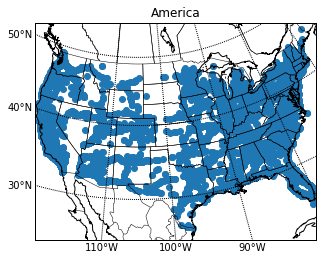

In [468]:
map = Basemap(projection='stere',lat_0=90,lon_0=-105,\
            llcrnrlat=23.41 ,urcrnrlat=45.44,\
            llcrnrlon=-118.67,urcrnrlon=-64.52,\
            rsphere=6371200.,resolution='l',area_thresh=10000)
map.drawmapboundary()   
map.drawstates()        
map.drawcoastlines()    
map.drawcountries()     
#map.drawcounties()      

parallels = np.arange(0.,90,10.) 
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10) 

meridians = np.arange(-110.,-60.,10.)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10) 

RTA_2018 = RTA_final.filter(year('Start_Time').alias('year') == 2018)

lat = RTA_2018.select('Start_Lat').toPandas().values
lon = RTA_2018.select('Start_Lng').toPandas().values

x,y = map(lon,lat)

plt.scatter(x,y,cmap=cm.hsv)
#map.scatter(x,y)
plt.title('America')
plt.show()


### Humidity

In [483]:
def calculateFrequency_Nosum(rdd):
    rdd_mapped = rdd.map(lambda x: (x,1))
    rdd_grouped = rdd_mapped.groupByKey()
    rdd_frequency = rdd_grouped.mapValues(sum).map(lambda x: (x[1],x[0])).sortByKey(False)
    #rdd_frequency_total = rdd_frequency.map(lambda x: x[0])
    return rdd_frequency.take(10)

In [484]:
humidity_df = RTA_final.select('`Humidity(%)`')
humidity_rdd = humidity_df.rdd.map(lambda x: x.asDict()).map(lambda x: x.get('Humidity(%)'))
#humidity_rdd.take(10)
calculateFrequency_Nosum(humidity_rdd)

[(26583, 93.0),
 (24886, 100.0),
 (16614, 90.0),
 (16175, 87.0),
 (13414, 96.0),
 (12909, 84.0),
 (12762, 78.0),
 (12571, 81.0),
 (12391, 65.0),
 (12358, 89.0)]